# Plot effects of dicodon length and periodicity on mRNA levels

## Load libraries and define analysis-specific parameters

- We need to install both rsample and rasilabRtemplates in the Docker / Singularity container (or R conda environement?)

In [1]:
library(Biostrings)
library(tidyverse)
# library(rasilabRtemplates)

insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

# Color-blind friendly palette. See http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:



## Read back barcode counts 

This is calculated in [plot_alignment_statistics.ipynb](plot_alignment_statistics.md).

In [5]:
barcode_counts <- read_tsv('../tables/sample_insert_barcode_counts.tsv.gz') %>% 
  print()

Rows: 84782 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): sample_id, sample_name, library_type, linkage_ref
dbl (4): insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 84,782 × 8
   sample_id sample_name insert_num barcode_num barcode_count linkage_count
   <chr>     <chr>            <dbl>       <dbl>         <dbl>         <dbl>
 1 107p7     didi_grna_1         86       47695          4582            26
 2 107p7     didi_grna_1         22       17334          4086             6
 3 107p7     didi_grna_1        172        6711          4078             1
 4 107p7     didi_grna_1         20        5501          4068             1
 5 107p7     didi_grna_1        275        2109          3889             1
 6 107p7     didi_grna_1         54       46374          3821            25
 7 107p7     didi_grna_1        150       49997          3797            29
 8 107p7     didi_grna_1        236        1823          3785             1
 9 107p7     didi_grna_1         90       41296          3778            20
10 107p7     didi_grna_1        227       26592          3694            11
# … with 84,772 more rows, and 2 more variables: library_type <ch

ERROR: Error in eval(expr, envir, enclos): object 'ddd' not found


In [20]:
replicate_annotations <- read_csv("../annotations/replicate_annotations.csv") %>% 
  select(sample_num, sample_name, sample_type, replicate) %>% 
  print()

Rows: 4 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_id, illumina_index, sample_name, sample_type, linkage_ref
dbl (2): replicate, sample_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4 × 4
  sample_num sample_name sample_type replicate
       <dbl> <chr>       <chr>           <dbl>
1          1 didi_grna_1 grna                1
2          2 didi_grna_2 grna                2
3          3 didi_mrna_1 mrna                1
4          4 didi_mrna_2 mrna                2



## Read insert annotations 

In [48]:

insert_annotations <- read_tsv("../../pool2_linkage/annotations/insert_annotations.tsv") %>% 
  arrange(insert_num) %>%
  print()

Rows: 317 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): seq, insert_name
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 317 × 3
   insert_num seq                                              insert_name      
        <dbl> <chr>                                            <chr>            
 1          0 AAGATCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 2          1 AAGATCAAGATCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 3          2 AAGATCAAGATCAAGATCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 4          3 AAGATCAAGATCAAGATCAAGATCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 5          4 AAGATCAAGATCAAGATCAAGATCAAGATCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 6          5 AAGATCAAGATCAAGATCAAGATCAAGATCAAGATCTCCGGCTCCGGC varydicodonrepea…
 7          6 AAGATCAAGATCAAGATCAAGATCAAGATCAAGATCAAGATCTCCGGC varydicodonrepea…
 8          7 AAGATCAAGATCAAGATCAAGATCAAGATCAAGATCAAGATCAAGATC varydicodonrepea…
 9          8 AAGTTCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
10          9 AAGTTCAAGTTCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
# … with

## Combine counts and annotations

In [49]:
counts <- barcode_counts %>% 
  left_join(replicate_annotations, by  = "sample_name") %>% 
  left_join(insert_annotations, by = "insert_num") %>% 
  print()

counts

# A tibble: 84,782 × 13
   sample_id sample_name insert_num barcode_num barcode_count linkage_count
   <chr>     <chr>            <dbl>       <dbl>         <dbl>         <dbl>
 1 107p7     didi_grna_1         86       47695          4582            26
 2 107p7     didi_grna_1         22       17334          4086             6
 3 107p7     didi_grna_1        172        6711          4078             1
 4 107p7     didi_grna_1         20        5501          4068             1
 5 107p7     didi_grna_1        275        2109          3889             1
 6 107p7     didi_grna_1         54       46374          3821            25
 7 107p7     didi_grna_1        150       49997          3797            29
 8 107p7     didi_grna_1        236        1823          3785             1
 9 107p7     didi_grna_1         90       41296          3778            20
10 107p7     didi_grna_1        227       26592          3694            11
# … with 84,772 more rows, and 7 more variables: library_type <c

sample_id,sample_name,insert_num,barcode_num,barcode_count,linkage_count,library_type,linkage_ref,sample_num,sample_type,replicate,seq,insert_name
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
107p7,didi_grna_1,86,47695,4582,26,grna,didi_linkage_1,1,grna,1,CGTGAACGTGAACGTGAACGTGAACGTGAACGTGAACGTGAATCCGGC,varydicodonrepeatlength_CGTGAA_7
107p7,didi_grna_1,22,17334,4086,6,grna,didi_linkage_1,1,grna,1,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTCCGGC,varydicodonrepeatlength_AGAGAG_7
107p7,didi_grna_1,172,6711,4078,1,grna,didi_linkage_1,1,grna,1,AAAGTCAAAGTCAAAGTCAAAGTCAGTTTCAGTTTCAGTTTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_4
107p7,didi_grna_1,20,5501,4068,1,grna,didi_linkage_1,1,grna,1,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTCCGGCTCCGGCTCCGGC,varydicodonrepeatlength_AGAGAG_5
107p7,didi_grna_1,275,2109,3889,1,grna,didi_linkage_1,1,grna,1,TCCAGTTTCTCCAGTTTCTCCAGTTTCTCCAGTTTCTCCAGTTTCTCC,reorderdicodon_AGTTTC_1
107p7,didi_grna_1,54,46374,3821,25,grna,didi_linkage_1,1,grna,1,ATGATGATGATGATGATGATGATGATGATGATGATGATGATGTCCGGC,varydicodonrepeatlength_ATGATG_7
107p7,didi_grna_1,150,49997,3797,29,grna,didi_linkage_1,1,grna,1,TTGATGTTGATGTTGATGTTGATGTTGATGTTGATGTTGATGTCCGGC,varydicodonrepeatlength_TTGATG_7
107p7,didi_grna_1,236,1823,3785,1,grna,didi_linkage_1,1,grna,1,GTCAAACATCGCGTCAAACATCGCGTCAAACATCGCGTCAAACATCGC,mixdicodons_GTCAAA_CATCGC_1
107p7,didi_grna_1,90,41296,3778,20,grna,didi_linkage_1,1,grna,1,CTCATACTCATACTCATATCCGGCTCCGGCTCCGGCTCCGGCTCCGGC,varydicodonrepeatlength_CTCATA_3


### Plot correlation between mRNA and gDNA counts for all inserts in both samples


`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


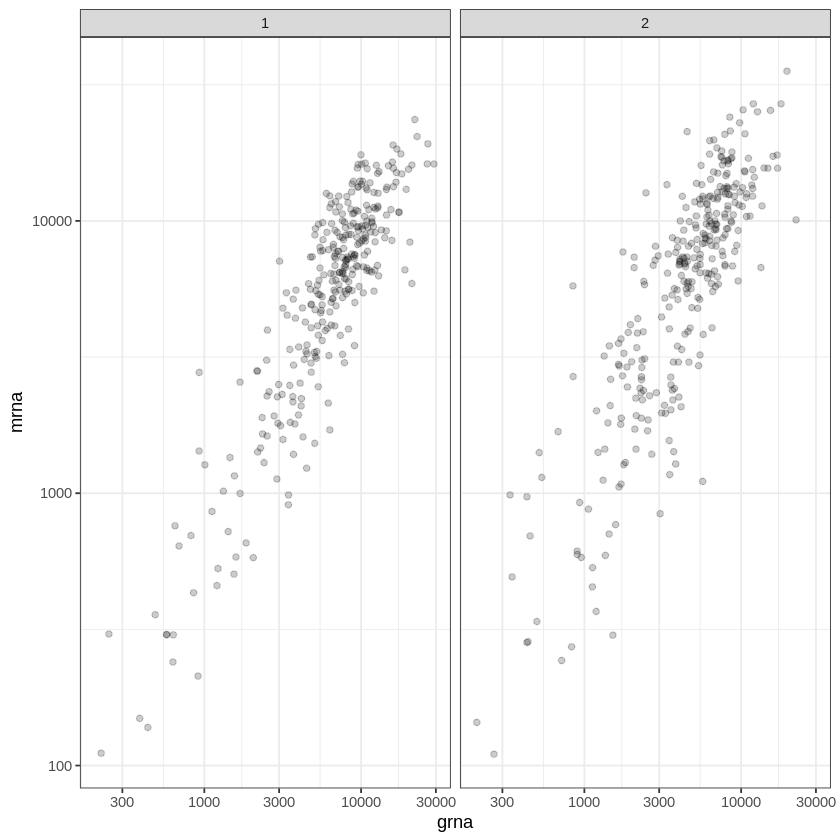

In [50]:
counts %>% 
  select(barcode_num, sample_type, replicate, barcode_count, insert_num) %>%
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  drop_na() %>%
  filter(grna > 100, mrna > 100) %>% 
  group_by(insert_num, replicate) %>%
  arrange(-(grna + mrna)) %>%
  # This selects the number of barcodes for each sample
  # slice(1:3) %>%
  summarize(grna = sum(grna), mrna = sum(mrna)) %>% 
  ungroup() %>%
  arrange(insert_num, replicate) %>%
  ggplot(aes(x = grna, y = mrna)) +
  facet_wrap(~ replicate) +
  geom_point(alpha = 0.2) +
  scale_x_log10() +
  scale_y_log10() +
  theme_bw()

## Function for bootstrap mRNA levels

In [51]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna))
}

## Calculate mRNA levels for each insert

Filter for inserts with at least 6 barcodes total and 200 reads total

Log fold change is log2(mRNA/gRNA) (calculated above in the lfc bootstrapp function) and is median-normalized across the full library.

In [52]:
lfc <- counts %>% 
  select(barcode_num, sample_type, replicate, barcode_count, insert_num) %>%
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  drop_na() %>%
  group_by(insert_num, replicate) %>% 
  nest() %>% 
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  group_by(replicate) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  ungroup() %>%
  print()


# A tibble: 634 × 4
   replicate insert_num    lfc lfc_sd
       <dbl>      <dbl>  <dbl>  <dbl>
 1         1         86 -0.143  0.273
 2         1         22 -1.94   0.339
 3         1        172 -1.99   0.421
 4         1         20 -0.338  0.331
 5         1        275  0.614  0.261
 6         1         54  0.687  0.474
 7         1        150  0.876  0.329
 8         1        236 -0.630  0.408
 9         1         90 -0.204  0.410
10         1        227  0.117  0.432
# … with 624 more rows


## Compare insert mRNA level effects of the two replicates

# A tibble: 317 × 3
   insert_num  lfc_1   lfc_2
        <dbl>  <dbl>   <dbl>
 1         86 -0.143  0.0873
 2         22 -1.94  -1.46  
 3        172 -1.99  -2.22  
 4         20 -0.338 -0.117 
 5        275  0.614  0.453 
 6         54  0.687  1.25  
 7        150  0.876  0.374 
 8        236 -0.630 -0.306 
 9         90 -0.204  1.27  
10        227  0.117  0.352 
# … with 307 more rows


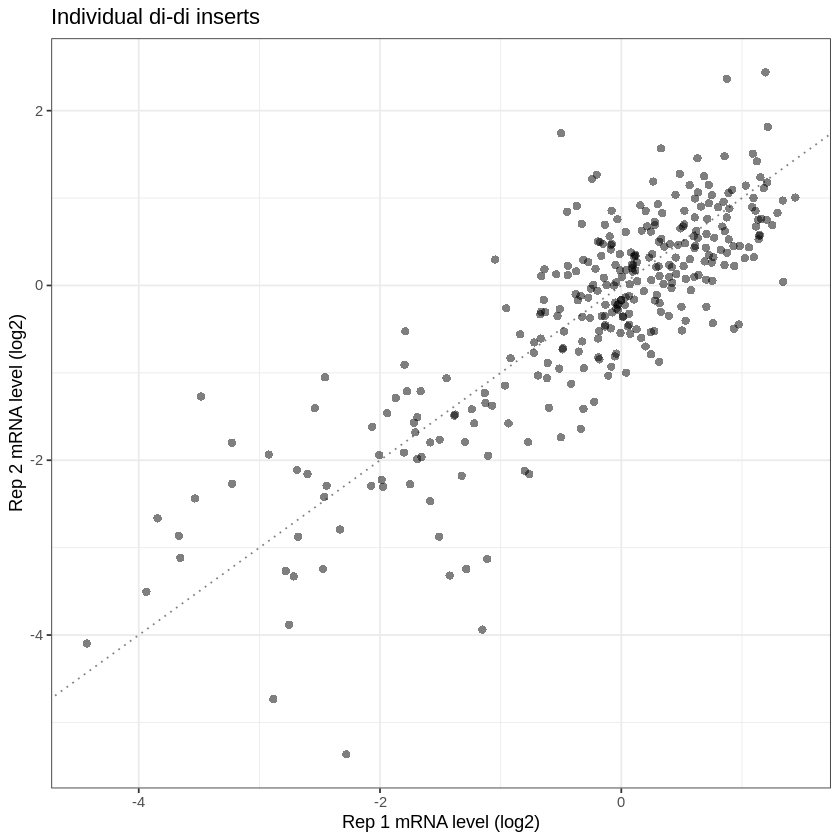

In [53]:
plot_data <- lfc %>% 
  select(insert_num, replicate, lfc) %>% 
  pivot_wider(names_from = replicate, values_from = lfc, names_prefix = "lfc_") %>%
  print()

plot_data %>% 
  ggplot(aes(x = lfc_1, y = lfc_2)) +
  geom_point(alpha = 0.5, shape = 16, size = 2)  +
  geom_abline(slope = 1, linetype = "dotted", alpha = 0.5) +
  labs(x = "Rep 1 mRNA level (log2)", y = "Rep 2 mRNA level (log2)",
       title = "Individual di-di inserts") +
  theme_bw() 

## Which inserts have lowest mRNA levels?

In [54]:

insert_lfc <- lfc %>% 
  left_join(insert_annotations, by = "insert_num") %>% 
  group_by(insert_num) %>% 
  mutate(mean_lfc = mean(lfc)) %>% 
  ungroup() %>% 
  arrange(mean_lfc) %>% 
  select(-insert_num) %>% 
  mutate(insert = as.character(translate(DNAStringSet(seq), no.init.codon = T))) %>% 
  write_tsv("../tables/insert_mrna_lfc.tsv.gz")

insert_lfc  

replicate,lfc,lfc_sd,seq,insert_name,mean_lfc,insert
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,-4.431542,1.1766643,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTCCGGCTCCGGC,varydicodonrepeatlength_TACAAG_6,-4.264207,YKYKYKYKYKYKSGSG
2,-4.096873,1.2462309,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTCCGGCTCCGGC,varydicodonrepeatlength_TACAAG_6,-4.264207,YKYKYKYKYKYKSGSG
1,-2.279123,0.8282918,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,varydicodonrepeatlength_CGCCAT_8,-3.821982,RHRHRHRHRHRHRHRH
2,-5.364841,1.3145912,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,varydicodonrepeatlength_CGCCAT_8,-3.821982,RHRHRHRHRHRHRHRH
1,-2.883833,0.7001261,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAG,varydicodonrepeatlength_TACAAG_8,-3.808059,YKYKYKYKYKYKYKYK
2,-4.732285,0.6529876,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAG,varydicodonrepeatlength_TACAAG_8,-3.808059,YKYKYKYKYKYKYKYK
1,-3.936620,1.3876382,AAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_1,-3.720964,KVSFKVSFKVSFKVSF
2,-3.505307,0.7932559,AAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_1,-3.720964,KVSFKVSFKVSFKVSF
1,-3.654816,0.6938261,AGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTC,mixdicodons_AGTTTC_AAAGTC_1,-3.385776,SFKVSFKVSFKVSFKV


## How does mRNA level vary with dicodon repeat length?

# A tibble: 168 × 8
   replicate    lfc lfc_sd seq              dicodon repeat_length mean_lfc diaa 
       <dbl>  <dbl>  <dbl> <chr>            <chr>   <chr>            <dbl> <fct>
 1         1 -3.53   1.15  AAGATCAAGATCAAG… AAGATC  8               -2.99  KI   
 2         1 -1.51   0.521 AAGATCAAGATCAAG… AAGATC  7               -1.64  KI   
 3         1 -0.763  0.631 AAGATCAAGATCAAG… AAGATC  6               -1.46  KI   
 4         1 -1.10   0.557 AAGATCAAGATCAAG… AAGATC  5               -1.53  KI   
 5         1 -0.310  0.329 AAGATCAAGATCAAG… AAGATC  4               -0.628 KI   
 6         1  0.288  0.316 AAGATCAAGATCAAG… AAGATC  3                0.249 KI   
 7         1  0.278  0.333 AAGATCAAGATCTCC… AAGATC  2                0.484 KI   
 8         1 -0.450  0.333 AAGATCTCCGGCTCC… AAGATC  1                0.196 KI   
 9         1 -2.54   0.431 AAGTTCAAGTTCAAG… AAGTTC  8               -1.97  KF   
10         1 -2.92   0.458 AAGTTCAAGTTCAAG… AAGTTC  7               -2.43  KF   
# … with

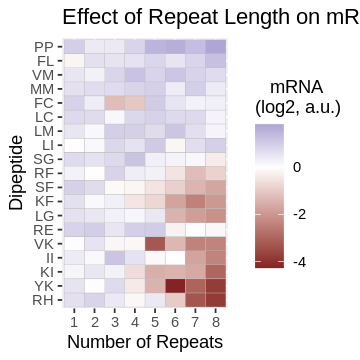

In [82]:
options(repr.plot.width=3, repr.plot.height=3)

plot_data <- insert_lfc %>%
  filter(str_detect(insert_name, "varydicodonrepeatlength")) %>% 
  separate(insert_name, c("insert_type", "dicodon", "repeat_length")) %>% 
  mutate(diaa = as.character(translate(DNAStringSet(dicodon,), no.init.codon = T))) %>% 
  group_by(seq) %>%
  slice(1) %>% 
  ungroup() %>% 
  group_by(diaa) %>%
  mutate(temp = min(mean_lfc[repeat_length == "8"])) %>%
  ungroup() %>%
  mutate(diaa = fct_reorder(diaa, -temp)) %>%
  select(-insert, - insert_type, -temp) %>%
  print()

plot_data %>% 
  ggplot(aes(x = repeat_length, y = fct_rev(diaa), fill = mean_lfc)) +
  geom_tile(color = 'grey') +
  scale_fill_gradient2() +
  labs(x = "Number of Repeats", y = "Dipeptide", fill = "   mRNA\n(log2, a.u.)",
       title = "Effect of Repeat Length on mRNA level")  

## Plot length effects for destabilizing dipeptide only

- set RH8 as lowest for heatmap purposes, since YK6 being lowest is likely suprious. 

# A tibble: 72 × 8
   replicate     lfc lfc_sd seq             dicodon repeat_length mean_lfc diaa 
       <dbl>   <dbl>  <dbl> <chr>           <chr>   <chr>            <dbl> <fct>
 1         1 -3.48    0.594 ATCATCATCATCAT… ATCATC  8              -2.38   II   
 2         1 -2.46    0.542 ATCATCATCATCAT… ATCATC  7              -1.75   II   
 3         1 -0.214   0.416 ATCATCATCATCAT… ATCATC  6              -0.0112 II   
 4         1 -0.0328  0.471 ATCATCATCATCAT… ATCATC  5              -0.130  II   
 5         1  0.340   0.282 ATCATCATCATCAT… ATCATC  4               0.584  II   
 6         1  0.856   0.415 ATCATCATCATCAT… ATCATC  3               1.17   II   
 7         1  0.499   0.313 ATCATCATCATCTC… ATCATC  2               0.128  II   
 8         1  0.357   0.430 ATCATCTCCGGCTC… ATCATC  1               0.401  II   
 9         1 -2.54    0.431 AAGTTCAAGTTCAA… AAGTTC  8              -1.97   KF   
10         1 -2.92    0.458 AAGTTCAAGTTCAA… AAGTTC  7              -2.43   KF   
# … with 

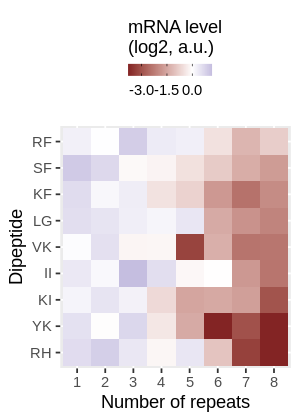

In [88]:
options(repr.plot.width=2.5, repr.plot.height=3.5)

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "varydicodonrepeatlength")) %>% 
  separate(insert_name, c("insert_type", "dicodon", "repeat_length")) %>% 
  # we skip these two dicodons and plot them separately since they are peculiar, 
  # they have another synonymous dicodon in this group
  filter(!dicodon %in% c("AGAGAG", "CTCATA")) %>%
  mutate(diaa = as.character(translate(DNAStringSet(dicodon,), no.init.codon = T))) %>% 
  group_by(insert) %>%
  slice(1) %>%
  ungroup() %>%
  group_by(diaa) %>%
  mutate(temp = min(mean_lfc[repeat_length == "8"])) %>%
  ungroup() %>%
  filter(temp < -0.5) %>% 
  mutate(diaa = fct_reorder(diaa, -temp)) %>%
  select(-insert, - insert_type, -temp) %>%
  mutate(mean_lfc = case_when(mean_lfc < -3.8 ~ -3.8, T ~ mean_lfc)) %>% 
  print()

plot_data %>% 
  complete(diaa, repeat_length) %>% 
  ggplot(aes(x = repeat_length, y = fct_rev(diaa), fill = mean_lfc)) +
  geom_tile() +
  scale_fill_gradient2(breaks = c(0, -1.5, -3),
                       na.value = "grey50", 
                       guide = guide_colorbar(barwidth = 3.5, barheight = 0.5, ticks.colour = "black", title.position = "top")) +
  labs(x = "Number of repeats", y = "Dipeptide", fill = "mRNA level\n(log2, a.u.)") +
  theme(axis.line = element_blank(), legend.position = "top") 
  
ggsave("../figures/destabilizing_dipeptide_length_effect.pdf", width = 2.5, height = 3.5)   

## Show replicability for above plot

# A tibble: 72 × 4
   diaa  repeat_length lfc_1 lfc_2
   <chr> <chr>         <dbl> <dbl>
 1 YK    6             -4.43 -4.10
 2 RH    8             -2.28 -5.36
 3 YK    8             -2.88 -4.73
 4 RH    7             -2.75 -3.88
 5 VK    5             -3.67 -2.86
 6 YK    7             -2.78 -3.27
 7 KI    8             -3.53 -2.44
 8 KF    7             -2.92 -1.93
 9 VK    7             -2.69 -2.11
10 II    8             -3.48 -1.27
# … with 62 more rows


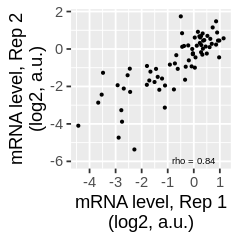

In [91]:
options(repr.plot.width=2, repr.plot.height=2)

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "varydicodonrepeatlength")) %>% 
  separate(insert_name, c("insert_type", "dicodon", "repeat_length")) %>% 
  # we skip these two dicodons and plot them separately since they are peculiar
  filter(!dicodon %in% c("AGAGAG", "CTCATA")) %>%
  mutate(diaa = as.character(translate(DNAStringSet(dicodon,), no.init.codon = T))) %>% 
  group_by(diaa) %>%
  mutate(temp = min(mean_lfc[repeat_length == "8"])) %>%
  ungroup() %>%
  filter(temp < -0.5) %>% 
  select(replicate, lfc, diaa, repeat_length) %>% 
  mutate(replicate = as.character(replicate)) %>% 
  pivot_wider(names_from = replicate, values_from = lfc, names_prefix = "lfc_") %>%
  print()

plot_data %>% 
  ggplot(aes(x = lfc_1, y = lfc_2)) +
  geom_point(size = 0.5) +
  labs(x = "mRNA level, Rep 1\n(log2, a.u.)", y = "mRNA level, Rep 2\n(log2, a.u.)") +
  annotate("text", x=0, y=-6, label="rho = 0.84", size = 2)